# Build Random Forest Classifier Models

## Import Processed Data

In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
from sklearn.externals import joblib
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [2]:
# set path of the processed data
processed_data_path = Path.cwd().parent / 'data' / 'processed'
train_processed_file_path = processed_data_path /'train_processed.csv'
test_processed_file_path = processed_data_path / 'test_processed.csv'
unlabeled_processed_file_path = processed_data_path / 'unlabeled_processed.csv'

# create data frames for train, test, and unlabled data
train_df = pd.read_csv(train_processed_file_path, index_col = 'ImageId')
test_df = pd.read_csv(test_processed_file_path, index_col = 'ImageId')
unlabeled_df = pd.read_csv(unlabeled_processed_file_path, index_col = 'ImageId')

In [3]:
# in the train and test data, X contains all the columns except 'label'
# y is 'label'
X_train = train_df.drop(['label'], axis = 1)
y_train = train_df['label']
X_test = test_df.drop(['label'], axis = 1)
y_test = test_df['label']

## PCA

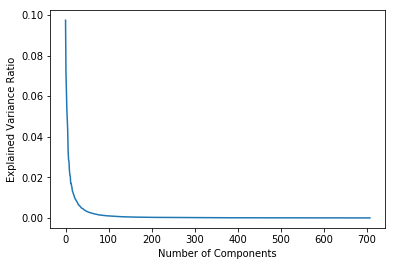

In [4]:
# let's look at how explained variance ratio varies with number of components
import matplotlib.pyplot as plt
%matplotlib inline

pca = PCA(random_state = 42)
pca.fit(X_train)

plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.show()

In [5]:
# it looks like we can get away with using about 50 components
pca = PCA(n_components = 50,
          random_state = 42).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
unlabeled_pca = pca.transform(unlabeled_df)

## Default Random Forest Classifier (with PCA)

In [6]:
# use 5-fold CV to evaluate accuracy with pca-train data
model = RandomForestClassifier(random_state = 42)
scores = cross_val_score(model, X_train_pca, y_train, cv = 5)

print('CV accuracty mean: ' + '{0:2f}'.format(scores.mean()))
print('CV accuracty std: ' + '{0:2f}'.format(scores.std()))
print('CV scores:', scores)

CV accuracty mean: 0.905954
CV accuracty std: 0.004437
CV scores: [0.90096654 0.9056688  0.90117577 0.9106877  0.91126991]


## Tuned Random Forest Classifier (with PCA)

Not a particularly sophisticated search for optimal parameters. I need to think more about the smorgasbord of options for tuning a random forest...in the meantime, tuning n_estimators is simple enough.

In [7]:
# define the parameter values that will be considered
num_of_estimators = [300, 350]
params = {'n_estimators' : num_of_estimators}

# used to evaluate all possible combinations with 5-fold cross-validation
grid_search = GridSearchCV(RandomForestClassifier(random_state = 42),
                           param_grid = params,
                           cv = 5,
                           refit = True,
                           return_train_score = True)

# fit
grid_search.fit(X_train_pca, y_train)

# return the optimal combo of parameters and its score
print(grid_search.best_params_, '\n')
print(grid_search.best_score_)

{'n_estimators': 300} 

0.9474404761904762


In [8]:
# use 5-fold CV to evaluate accuracy with pca-train data
model = RandomForestClassifier(random_state = 42,
                               n_estimators = 300)
scores = cross_val_score(model, X_train_pca, y_train, cv = 5)

print('CV accuracty mean: ' + '{0:2f}'.format(scores.mean()))
print('CV accuracty std: ' + '{0:2f}'.format(scores.std()))
print('CV scores:', scores)

CV accuracty mean: 0.947441
CV accuracty std: 0.002863
CV scores: [0.94557621 0.94881714 0.94284864 0.95087824 0.94908441]


In [9]:
# fit model to entire train set
model = RandomForestClassifier(random_state = 42,
                               n_estimators = 300).fit(X_train_pca, y_train)

# evaluate accuracy on test set
print('Tuned RF (w/PCA) Accuracy: ' + '{0:2f}'.format(model.score(X_test_pca, y_test)))

Tuned RF (w/PCA) Accuracy: 0.950952


## Model Persistence

Probably not worth submitting RF predictions to Kaggle, but we might use this model in an ensemble later.

In [10]:
# Note: the PCA tool was persisted in the KNN notebook, so no need to do it again

# create file paths
model_file_path = Path.cwd().parent / 'models' / 'rf_model.pkl'

# persist the model and pca
joblib.dump(model, model_file_path);

#### Optional: Check the persisted model

In [11]:
# create file paths
pca_file_path = Path.cwd().parent / 'models' / 'pca_50.pkl'
model_file_path = Path.cwd().parent / 'models' / 'rf_model.pkl'

# load
pca_loaded = joblib.load(pca_file_path)
model_loaded = joblib.load(model_file_path)

In [12]:
# print the model object description
model_loaded

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [13]:
# print the pca object description
pca_loaded

PCA(copy=True, iterated_power='auto', n_components=50, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)

In [14]:
# transform the test data using loaded pca object
X_test_pca = pca_loaded.transform(X_test)

# calculate the score using the loaded model object
# we should get 0.950952, as above
print('Persisted RF (w/PCA) Accuracy: ' + '{0:2f}'.format(model_loaded.score(X_test_pca, y_test)))

Persisted RF (w/PCA) Accuracy: 0.950952


## Error Analysis

In [15]:
# imports
from sklearn.model_selection import cross_val_predict

In [16]:
# instead of scoring, get the cross-validated estimates for each image
y_train_pred = cross_val_predict(model, X_train_pca, y_train, cv = 5)

In [17]:
# now let's take a look at the confusion matrix to see
# which actual labels (rows) do not match the predicted label (columns)
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(y_train, y_train_pred)
print(np.matrix(conf_mx))

[[3238    0    5    4    5    7   33    3   10    1]
 [   0 3666   24   15    2    8   10    4   14    4]
 [  20    8 3138   42   23    4   14   30   59    4]
 [   8    5   49 3227    0   63   15   25   57   32]
 [   2   16   21    2 3068    3   26    7   15   98]
 [  16    0   12   63   22 2852   32    3   20   16]
 [  26    4   13    0    7   32 3220    0    7    0]
 [   5   23   43    5   23    0    1 3352   11   58]
 [   5   22   24   86   18   44   13   12 2998   28]
 [  16    8    7   58   78   11    3   59   35 3075]]


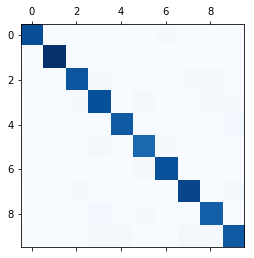

In [18]:
# color-coding might be easier to look at than a bunch of numbers:
# the darker, the bigger the value; the whiter, the smaller the value
plt.matshow(conf_mx, cmap = plt.cm.Blues);

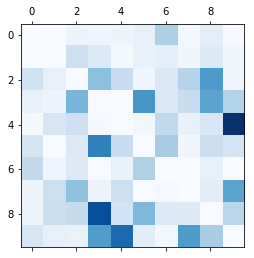

In [19]:
# well, this just confirms that the model is very accurate, which we already know...
# let's look at error rates by dividing by the number of images in each label (row sum)
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx / row_sums

# we only want errors, so let's fill the diagonal with zeros
np.fill_diagonal(norm_conf_mx, 0)

# plot
plt.matshow(norm_conf_mx, cmap = plt.cm.Blues);

As with KNN and SVC, the biggest problem is that many 4s are mislabeled as 9s. The following are pairs that are mislabeled in both directions: 4s and 9s, 7s and 9s, 3s and 5s, 3s and 8s, and 2s and 3s.

Other problems: 2s are mislabeled as 8s, 9s are mislabeled as 3s, 3s are mislabeled as 8s, and 8s are mislabeled as 5s.

Remedies include those mentioned in the KNN notebook. However, I think I might instead build a few more classifiers, then use ensemble techniques to (hopefully) increase accuracy beyond the current high score (0.98200).